In [1]:
import numpy as np 
from IPython.display import Image 
import branca.colormap as cm
import pandas as pd 
import seaborn as sns 
import plotly.express as px
from plotly.offline import init_notebook_mode, iplot
import seaborn as sns
import matplotlib.pyplot as pl
from sklearn.preprocessing import LabelEncoder
import imblearn
from collections import Counter
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, f1_score,recall_score, precision_score
from sklearn.metrics import average_precision_score, roc_auc_score, roc_curve, auc
from xgboost import XGBClassifier
import matplotlib
import imblearn
import folium
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


/kaggle/input/telco-customer-churn/WA_Fn-UseC_-Telco-Customer-Churn.csv
/kaggle/input/telco-customer-churn-ibm-dataset/Telco_customer_churn.xlsx


In [2]:
!pip install h3

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 28.4 MB/s eta 0:00:00


In [3]:
import h3

In [4]:
# we will do some geographical maps buildings, so maybe you need to install keplergl and h3 :)

#!pip install ipywidgets
#!pip install keplergl
#!jupyter nbextension install --py --sys-prefix keplergl
#!jupyter nbextension enable keplergl --py --sys-prefix
#!pip install h3
#!pip install h3pandas

* [Introduction](#1)
* [Checking for missing values](#2)
    * [Replacing missing values](#3)
* [Exploratory Data Analysis](#4)
    * [General Churn Rate](#5)
    * [Geography of the customer](#6)
        * [Let's add visualization by hexagons](#7)
    * [Customer's lifetime in the service](#8)
    * [What were the reasons for the churn mentioned by customers?](#9)
    * [Contract types](#10)
    * [Total and monthly charges of customers](#11)
    * [What services do customers use?](#12)
        * [Internet type](#13)
        * [Tech support and online security](#14)
    * [Payment methods](#15)
    * [Gender and age of customers](#16)
    * [The impact of having a partner and/or dependants](#17)
* [Preparing data for the model](#18)
    * [Deleting the columns that we won't use](#19)
    * [Changing categorical variables to numeric](#20)
    * [Balancing the data](#21)
* [Churn prediction model](#22)
* [Conclusion](#23)

<a id="1"></a>
# Introduction

<a id="2"></a> <br>

<div> Hello folks!</div>  
<div> I had a small (five-year lol) pause in posting my notebooks here.</div>  
<div> I am so happy that you are reading my work now, but I must warn you that I work as a product analyst, so I will devote most of my time to data analysis and visualizations, and less to building an churn prediction model.</div>
But I hope it will be interesting and useful! 
<div> let's go :) </div>


Today we will analyze a data set containing information about Telco Telecom customers and find out what could be the reason for their churn from the service, as well as build an churn prediction model.

The first step is to see what customer data we have, whether there are missing values, and so on.

In [5]:
data = pd.read_excel('/kaggle/input/telco-customer-churn-ibm-dataset/Telco_customer_churn.xlsx')

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 33 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   CustomerID         7043 non-null   object 
 1   Count              7043 non-null   int64  
 2   Country            7043 non-null   object 
 3   State              7043 non-null   object 
 4   City               7043 non-null   object 
 5   Zip Code           7043 non-null   int64  
 6   Lat Long           7043 non-null   object 
 7   Latitude           7043 non-null   float64
 8   Longitude          7043 non-null   float64
 9   Gender             7043 non-null   object 
 10  Senior Citizen     7043 non-null   object 
 11  Partner            7043 non-null   object 
 12  Dependents         7043 non-null   object 
 13  Tenure Months      7043 non-null   int64  
 14  Phone Service      7043 non-null   object 
 15  Multiple Lines     7043 non-null   object 
 16  Internet Service   7043 

A good set! We have data on: 
* what services customers use, 
* type of contract
* the lifetime of the client in the service
* payment method
* the amount of monthly payments of customers and their total costs in the service, 
* customer locations, 
* gender and age of the client
* reason for churn (for clients in the churn)

This data set already contains a prediction of churn from IBM, but we do not go in simple ways, so we will not peek and find out everything ourselves. 
![](https://pbs.twimg.com/media/E-VmJt9WEAAbBlG.jpg)

<a id="2"></a>
# Checking for missing values

1) Total Charges has a object data type, let's change data type for this column (money is number, right?

In [7]:
data['Total Charges'] = pd.to_numeric(data['Total Charges'], errors='coerce')

2) Let's check if we have some missing values in our dataset

In [8]:
data.isnull().sum()

CustomerID              0
Count                   0
Country                 0
State                   0
City                    0
Zip Code                0
Lat Long                0
Latitude                0
Longitude               0
Gender                  0
Senior Citizen          0
Partner                 0
Dependents              0
Tenure Months           0
Phone Service           0
Multiple Lines          0
Internet Service        0
Online Security         0
Online Backup           0
Device Protection       0
Tech Support            0
Streaming TV            0
Streaming Movies        0
Contract                0
Paperless Billing       0
Payment Method          0
Monthly Charges         0
Total Charges          11
Churn Label             0
Churn Value             0
Churn Score             0
CLTV                    0
Churn Reason         5174
dtype: int64

The Churn Reason has many missing values because not all of our customers are in the churn:

In [9]:
data.groupby('Churn Label')['CustomerID'].nunique()

Churn Label
No     5174
Yes    1869
Name: CustomerID, dtype: int64

5184 customers have a Churn Label = No, so they no need to have some Churn Reason. It is fine. 
<div>But what about Total Charges?</div>

In [10]:
data[data['Total Charges'].isna()]

,CustomerID,Count,Country,State,City,Zip Code,Lat Long,Latitude,Longitude,Gender,...,Contract,Paperless Billing,Payment Method,Monthly Charges,Total Charges,Churn Label,Churn Value,Churn Score,CLTV,Churn Reason
2234,4472-LVYGI,1,United States,California,San Bernardino,92408,"34.084909, -117.258107",34.084909,-117.258107,Female,...,Two year,Yes,Bank transfer (automatic),52.55,NaN,No,0,36,2578,NaN
2438,3115-CZMZD,1,United States,California,Independence,93526,"36.869584, -118.189241",36.869584,-118.189241,Male,...,Two year,No,Mailed check,20.25,NaN,No,0,68,5504,NaN
2568,5709-LVOEQ,1,United States,California,San Mateo,94401,"37.590421, -122.306467",37.590421,-122.306467,Female,...,Two year,No,Mailed check,80.85,NaN,No,0,45,2048,NaN
2667,4367-NUYAO,1,United States,California,Cupertino,95014,"37.306612, -122.080621",37.306612,-122.080621,Male,...,Two year,No,Mailed check,25.75,NaN,No,0,48,4950,NaN
2856,1371-DWPAZ,1,United States,California,Redcrest,95569,"40.363446, -123.835041",40.363446,-123.835041,Female,...,Two year,No,Credit card (automatic),56.05,NaN,No,0,30,4740,NaN
4331,7644-OMVMY,1,United States,California,Los Angeles,90029,"34.089953, -118.294824",34.089953,-118.294824,Male,...,Two year,No,Mailed check,19.85,NaN,No,0,53,2019,NaN
4687,3213-VVOLG,1,United States,California,Sun City,92585,"33.739412, -117.173334",33.739412,-117.173334,Male,...,Two year,No,Mailed check,25.35,NaN,No,0,49,2299,NaN
5104,2520-SGTTA,1,United States,California,Ben Lomond,95005,"37.078873, -122.090386",37.078873,-122.090386,Female,...,Two year,No,Mailed check,20.00,NaN,No,0,27,3763,NaN
5719,2923-ARZLG,1,United States,California,La Verne,91750,"34.144703, -117.770299",34.144703,-117.770299,Male,...,One year,Yes,Mailed check,19.70,NaN,No,0,69,4890,NaN
6772,4075-WKNIU,1,United States,California,Bell,90201,"33.970343, -118.171368",33.970343,-118.171368,Female,...,Two year,No,Mailed check,73.35,NaN,No,0,44,2342,NaN


We see that all clients for which there is no 'Total Charges' value are not in the churn, and also almost all of them have the same contract type - 'Two years', and one customer has 'One Year' contract.

<a id="3"></a>
## Replacing missing values

We can delete these 11 rows from the dataset and continue working, but can we just delete the data without trying other options?
<div> No! </div>

In our dataset, we have the number of months that the customer uses the service (Tenure Months), as well as his monthly payments (Monthly Charges). 
<div> Let's check if we can replace these values with those calculated through monthly charges.</div>
We know how many months customer is using service, so we can check if calulation : monthly charges * tenure months will have result equal to total charges value.
<div> Lrt's try it!

1) Calculating charges:

In [11]:
data['calc_charges'] = data['Monthly Charges'] * data['Tenure Months']

2) calculating difference between Total Charges and calculated charges

In [12]:
data['diff_in_charges'] = data['Total Charges'] - data['calc_charges']

Let's check if our idea is working!

In [13]:
fig = px.histogram(data, x="diff_in_charges",color = 'Contract',marginal="box")
fig.show()

<div> On the graph, we see the distribution of the difference between the actual total chargers of our customers and the values that we calculated by multiplying the monthly chargers and the number of months that the customer used the service.</div>
<div> The median difference is up to 1$ for all contract types (which means that for 50 percent of our customers, charges calculated by multiplying monthly charges by the number of months in the service are equal to the total charges that are presented in the dataset).

Quantiles:

In [14]:
data.groupby('Contract')[['Total Charges','diff_in_charges']].quantile([.50,.80,.90,.95])

Total Charges  diff_in_charges
Contract                                           
Month-to-month 0.50       679.5500           0.0000
               0.80      2485.7300          24.8100
               0.90      3844.0600          54.0200
               0.95      4966.9200          85.3300
One year       0.50      2657.5500           0.7750
               0.80      5286.4600          55.0500
               0.90      6341.2500          92.2000
               0.95      7072.4725         133.3375
Two year       0.50      3623.9500           0.5000
               0.80      6399.2400          61.5300
               0.90      7457.6100          97.5700
               0.95      7922.3400         139.1800

We can see that for 95 percent of customers the difference is less than 10% of the median total charges. In this case, it seems possible to replace the missing values of total charges with those calculated in terms of monthly charges and not delete these rows.

In [15]:
data['Total Charges'] = np.where(data['Total Charges'].isna() == True,data['calc_charges'], data['Total Charges'])

In [16]:
data = data.drop(['calc_charges','diff_in_charges'], axis=1)

We have solved the problem of missing values, now we can start analyzing data about our customers.

![welldone](https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcR5VBEh0if1RuVTXKdLAdyRyWF2r3YH04fxofgz1kYgubHJcI3d7FXFW4XHq2epD2bQjG4&usqp=CAU)

<a id="4"></a>
# Exploratory Data Analysis

<a id="5"></a>
## 1. General Churn Rate

<div> Our goal is to build a customer churn model. Therefore, first of all, we need to understand what factors have the greatest impact on the churn of customers from the service.
Churn customers are customers who have stopped using the service. </div>
<div> Let's introduce a metric - the churn rate (the percentage of customers who churned), and look at this metric in terms of the characteristics of the customers that we have.</div>

In [17]:
fig = px.pie(data.groupby('Churn Label')['CustomerID'].nunique().reset_index(), 
             values='CustomerID', 
             names='Churn Label')
fig.show()

Among the customers in the dataset, **26.5%**  of customers are in churn and have stopped using the company's services

Speaking from a business perspective, understanding the reasons for the outflow of customers is a critically important task. And the ability to predict that a customer may go into outflow can help save customers and profits.
<dir> So let's get started :) </dir>

<a id="6"></a>
## 2. Geography of the customer

![churn](https://pbs.twimg.com/media/FrHWM1paUAIHzZp.png)

Let's start with the geography of customers. We know the city, postal code and coordinates of the customers.

In [18]:
data.groupby(['Country','State'])['CustomerID'].count()

Country        State     
United States  California    7043
Name: CustomerID, dtype: int64

All of our clients are from the United States of America, California.

In [19]:
data['City'].nunique()

1129

There are 1129 unique cities in total in the dataset, so, let's check where our customers located and if geography of customer has impact to the churn rate

In [20]:
fig = px.scatter_mapbox(data.groupby(['Latitude','Longitude'])['CustomerID'].count().reset_index(), lat="Latitude", lon="Longitude", hover_data= ['CustomerID'], zoom=4, height=300)
fig.update_layout(mapbox_style="open-street-map")
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

We see the largest number of customers in the Los Angeles, San Diego, San Francisco area. (Logically, these are large cities :D )

In [21]:
fig = px.bar(data.groupby(['City'])['CustomerID'].count().reset_index().sort_values('CustomerID',
                                                                                    ascending=False).head(50),
             x='City',
             y='CustomerID', 
             color = 'CustomerID',
             text = 'CustomerID')
fig.show()

<a id="7"></a>
### Let's add visualization by hexagons

It's interesting, but looking at the number of clients by specific latitude and longitude may not be very clear. Let's try to see the number of customers and the percentage of churn customers by hexagons!

If you are interested in what hexagons are, then you can read this article - 
[Link]( https://www.uber.com/en-IN/blog/h3/)

<div> Dividing an area into hexagons is very convenient if we want to understand whether the value of the metric changes depending on the geographical location of the client, and entities such as a city or a country are very large. </div>
<div> Also, for example, Uber and other taxi ordering applications use hexagons in order to calculate supply and demand in a specific zone, adjust surge coefficients, and so on. </div>

We do not want to delve into the analysis of each individual city, so we will use a fairly large hexagon size - 5. Information about the size of hexagons is presented here - [Hexagones sizes info](https://h3geo.org/docs/core-library/restable/)

<div>But we can change this and get useful information, let's go! </div>

In [22]:
hex_level = 5

data['hex_id'] = data.apply(lambda x: h3.geo_to_h3(x['Latitude'], x['Longitude'], hex_level), axis=1)

hex_counts = data.groupby('hex_id')['CustomerID'].count().reset_index(name='total_clients')
hex_counts['center'] = hex_counts['hex_id'].apply(lambda x: h3.h3_to_geo(x))


color_range = [hex_counts['total_clients'].min(), hex_counts['total_clients'].max()]
colormap = cm.LinearColormap(["purple","red","orange","yellow","green"],vmin = min(color_range), vmax = max(color_range))

mean_lat, mean_lon = hex_counts['center'].apply(lambda x: x[0]).mean(), hex_counts['center'].apply(lambda x: x[1]).mean()
map_center = [mean_lat, mean_lon]
m = folium.Map(location=map_center, zoom_start=6, tiles='Stamen Terrain')

for _, row in hex_counts.iterrows():
    folium.Polygon(
        locations=h3.h3_to_geo_boundary(row['hex_id']),
        fill=True,
        fill_color=colormap(row['total_clients']),
        fill_opacity=0.7,
        stroke=False,
        tooltip=f"Number of clients: {row['total_clients']}"
    ).add_to(m)

colormap.caption = 'Number of clients'
m.add_child(colormap)

m

We see interesting hexagon with the largest number of customers in total.In general, we already know that there are many customers in Los Angeles and its surroundings. And what about the percentage of churn customers? We can also look at whether there are hexagons with an abnormally large or low percentage of churn customers.


Let's calculate churn rate for every hexagon

In [23]:
churn = data.assign(churn_clients = np.where(data['Churn Label']=='Yes',data['CustomerID'],None)).groupby(['hex_id']).agg({'churn_clients':'count'}).reset_index()

In [24]:
clients = data.groupby(['hex_id'])['CustomerID'].count().reset_index()

In [25]:
churn_data = clients.join(churn.set_index(['hex_id']), on=['hex_id'])

In [26]:
churn_data['churn_rate'] = churn_data['churn_clients']/churn_data['CustomerID']

In [27]:
churn_data

,hex_id,CustomerID,churn_clients,churn_rate
0,85280043fffffff,4,1,0.25
1,8528004bfffffff,4,1,0.25
2,8528004ffffffff,4,1,0.25
3,85280207fffffff,4,1,0.25
4,8528020bfffffff,4,1,0.25
...,...,...,...,...
709,85485b03fffffff,5,1,0.20
710,85485b33fffffff,5,1,0.20
711,85485b63fffffff,5,0,0.00
712,85485babfffffff,5,3,0.60


Soooooo, now we know!

In [28]:
churn_data['center'] = churn_data['hex_id'].apply(lambda x: h3.h3_to_geo(x))


color_range = [churn_data['churn_rate'].min(), churn_data['churn_rate'].max()]
colormap = cm.LinearColormap(["green","orange","red"],vmin = min(color_range), vmax = max(color_range))

mean_lat, mean_lon = churn_data['center'].apply(lambda x: x[0]).mean(), churn_data['center'].apply(lambda x: x[1]).mean()
map_center = [mean_lat, mean_lon]
m = folium.Map(location=map_center, zoom_start=6,  width='100%', height='80%',tiles='Stamen Terrain')

for _, row in churn_data.iterrows():
    folium.Polygon(
        locations=h3.h3_to_geo_boundary(row['hex_id']),
        fill=True,
        fill_color=colormap(row['churn_rate']),
        fill_opacity=0.7,
        stroke=False,
        tooltip=f"Churn rate: {row['churn_rate']}<br>Number of customers: {row['CustomerID']}"
    ).add_to(m)

colormap.caption = 'Churn rate'
m.add_child(colormap)

m

In general, we see that there are fewer hexagons in the Los Angeles area with a high percentage of customer churn (50+%). In some hexagons we see 80-100 percent of customers in outflow, but these are hexagons where in total <= 10 customers. 
<div> It is also important to note that there are more hexagons in the San Francisco and Sacramento area with a small total number of customers, in which 50+ percent of customers are in the churn. </div>

Let's build a scatter plot, where on the x-axis is the number of customers in hexagon, y - the churn rate : 

In [29]:
fig = px.scatter(churn_data, x="CustomerID",
                 y="churn_rate", 
                 size = 'churn_rate', 
                 color = 'churn_rate',
                 marginal_x="histogram")
fig.show()

We observe the churn rate above 25 percent only in hexagons, where we had a small number of customers.

Of course, we can still consider these hexagones with small number of customers and churn rate >= 50% as zones with abnormally high churn rate, but in the overall picture we do not see any geography of customers where our metric would behave totally different. Of course, we will also return to the customer geography when we look at services, payments, and so on. You can also experiment with the size of hexagons and maybe find something more interesting :)

<a id="8"></a>
## 3) Customer's lifetime in the service

Before we start looking at what services customers have used and their other characteristics, I think it is important to consider how long customers have used the service and after how many months in the service, customers begin to leave us.

Let's see how many months the clients who are in the churn used our service and is there a point when the largest number of customers stop using the service

In [30]:
fig = px.histogram(data, x="Tenure Months", color="Churn Label",marginal="box" )
fig.show()

In [31]:
data.groupby('Churn Label')['Tenure Months'].quantile([.50,.75,.90,.95])

Churn Label      
No           0.50    38.0
             0.75    61.0
             0.90    71.0
             0.95    72.0
Yes          0.50    10.0
             0.75    29.0
             0.90    51.0
             0.95    60.0
Name: Tenure Months, dtype: float64

In [32]:
data.groupby('Churn Label')['Tenure Months'].mean()

Churn Label
No     37.569965
Yes    17.979133
Name: Tenure Months, dtype: float64

50% of the customers who left the service did so in the first 10 months. The number of clients in the churn ceases to decline sharply after 5 months in the service.

SOOOOO CUSTOMERS JUST 5 MONTHS AND WE ARE OVER?!!! /heartbroken face/

![sadcat](https://gifdb.com/images/high/sad-cat-ok-thumbs-up-rk2abfw176m0uulb.gif)

The client's lifetime before the churn is very important information, Usually the first months in the service are the most risky, since customers may have their own expectations from the service and so on.

<a id="9"></a>
## What were the reasons for the churn mentioned by customers?

Well, we know that in general 26.5% of customers have stopped using our service and 50% of such customers have used our service for 10 months or less.

Now we can start analyzing our customer profile data to understand which type of customers are more likely to stop using our service and what actions we can take.

But before that, we can also look at the customer responses that we have in the Churn Reason column. Of course, customer survey data is often biased, as it contains the subjective opinion of the customer, but asking the opinion of customers is very important for any business that wants to develop and improve. Moreover, we have a lot of information with which we can verify customer responses.

Sooo let's see why customers left us (according to customers)

![why](https://media.makeameme.org/created/why-you-leave-5bdb44.jpg)

In [33]:
fig = px.bar(data.groupby(['Churn Reason'])['CustomerID'].count().reset_index().sort_values('CustomerID',
                                                                                    ascending=False),
             x='Churn Reason',
             y='CustomerID', 
             color = 'CustomerID',
             text = 'CustomerID')
fig.show()

I like the answer "I don't know". I feel these bro hahahahah

33.2% of churn customers left the service due to the fact that the competitor made the best offer (speed, data, devices).

17.3% of churn customers cited the attitude of a support specialist or provider as the reason.

We also have a number of reasons for the churn that we cannot influence in any way, such as relocation. I will remove them from the dataset, since there is little such data and they are irrelevant in the matter of understanding how we can retain customers.

In [34]:
data = data[data['Churn Reason'] != 'Moved']
data = data[data['Churn Reason'] != 'Deceased']

<a id="10"></a>
## Contract types

Let's see what types of contracts there are in the service and how this affects the churn rate.

In [35]:
fig = px.histogram(data, x="Churn Label", color="Contract", barmode="group",
                   title="Number of customers by contract type")
fig.update_layout(width=700, height=500, bargap=0.1)
fig.show()

In [36]:
fig = px.pie(data.groupby(['Contract','Churn Label'])['CustomerID'].count().reset_index(), 
             values='CustomerID', 
            names='Contract',
            facet_col = 'Churn Label',
            title = 'Churn rate by contract type')
            
fig.show()

88.7% of customers who left the service had a Month-to-month contract type. 

Perhaps longer types of contracts imply penalties for early termination of the contract, or these are mainly customers who wanted to test the service and were not satisfied

In [37]:
data.groupby(['Contract','Churn Label'])['Tenure Months'].mean()

Contract        Churn Label
Month-to-month  No             21.033333
                Yes            14.045455
One year        No             41.674063
                Yes            45.064103
Two year        No             56.602914
                Yes            61.270833
Name: Tenure Months, dtype: float64

Even for customers who are active in the service, we see the minimum average lifetime in the service for month-to-month contracts.This may be a specific type of contract for certain services, or customers switch to longer types of contracts only after some time of using the service.

<a id="11"></a>
## Total and monthly charges of clients

Let's look at the total and monthly chargers of customers. In the context of identifying the causes of  churn, we may be more interested in monthly charges, but the total costs may also be useful.

![money](https://img.memegenerator.net/instances/60542311.jpg)

**Total charges**

In [38]:
fig = px.histogram(data, x="Total Charges", color="Churn Label",
                   marginal="box"
                  )
fig.show()

<div> The median charges of customers who have gone into churn are more than 2 times lower than the median charges of customers who use the service </div>
<div> But this does not necessarily mean that customers who stopped using the service were less solvent. After all, we have already learned that many customers leave the service in the first 5 months of using the service </div>

Therefore, we look at the monthly chargers of customers.

**Monthly Charges**

In [39]:
fig = px.histogram(data, x="Monthly Charges", color="Churn Label",
                   marginal="box"
                  )
fig.show()

In [40]:
data.groupby('Churn Label')['Monthly Charges'].quantile([.50,.75,.95,.99])

Churn Label      
No           0.50     64.4250
             0.75     88.4000
             0.95    108.4175
             0.99    115.1000
Yes          0.50     79.5750
             0.75     94.2375
             0.95    105.6500
             0.99    111.1910
Name: Monthly Charges, dtype: float64

That's it! The median monthly charges of customers who have left the service are higher than those of customers who are still active. Since in the previous steps we did not identify the binding of a high churn to the client's location, this may be due to certain services and so on. We will certainly find out!

<a id="12"></a>
## Services used by the client

We have a flag for each service telling us which service the customer is using.
* Phone Service
* Internet Service
* Online Security
* Online Backup 
* Device Protection
* Multiple Lines
* Tech Support
* Streaming TV
* Streaming Movies


The list is large, so let's try to prioritize by looking at which variables correlate with the churn variable.

In [41]:
corr_df = data.copy()

In [42]:
corr_df['Churn Label'].replace(to_replace='Yes', value=1, inplace=True)
corr_df['Churn Label'].replace(to_replace='No',  value=0, inplace=True)

In [43]:
df_dummies = pd.get_dummies(corr_df[['Churn Label','Phone Service','Multiple Lines','Internet Service','Online Security',
                                 'Online Backup','Device Protection','Tech Support','Streaming TV',
                                 'Streaming Movies']])
df_dummies.head()

,Churn Label,Phone Service_No,Phone Service_Yes,Multiple Lines_No,Multiple Lines_No phone service,Multiple Lines_Yes,Internet Service_DSL,Internet Service_Fiber optic,Internet Service_No,Online Security_No,...,Device Protection_Yes,Tech Support_No,Tech Support_No internet service,Tech Support_Yes,Streaming TV_No,Streaming TV_No internet service,Streaming TV_Yes,Streaming Movies_No,Streaming Movies_No internet service,Streaming Movies_Yes
0,1,0,1,1,0,0,1,0,0,0,...,0,1,0,0,1,0,0,1,0,0
4,1,0,1,0,0,1,0,1,0,1,...,1,1,0,0,0,0,1,0,0,1
5,1,0,1,1,0,0,1,0,0,1,...,1,0,0,1,1,0,0,1,0,0
6,1,1,0,0,1,0,1,0,0,1,...,1,1,0,0,1,0,0,0,0,1
7,1,0,1,1,0,0,0,0,1,0,...,0,0,1,0,0,1,0,0,1,0


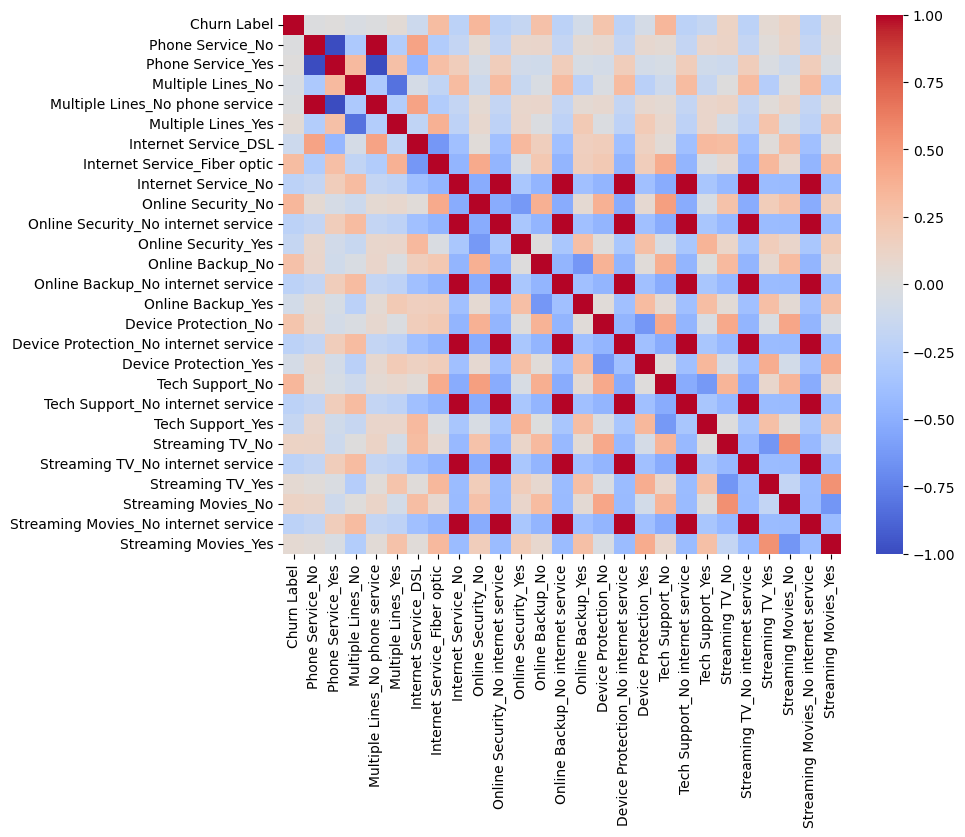

In [44]:
pl.figure(figsize=(9, 7))
sns.heatmap(df_dummies.corr(), annot=False, cmap='coolwarm')

pl.show()

In [45]:
fig = px.bar(df_dummies.corr()['Churn Label'].sort_values(ascending = False), 
             color = 'value')
fig.show()

So, we see:
* not connectiond a tech support,online security and online backup services has a correlation with churn value 
* fiber Optic Internet has a correlation with churn value

Let's take a look!

<a id="13"></a>
### Internet services

First, let's see what types of Internet services customers have, and then let's see their impact on the churn rate

In [46]:
fig = px.bar(data.groupby('Internet Service')['CustomerID'].count().reset_index(),
             x='Internet Service',
             y='CustomerID', 
             color = 'Internet Service',
             text = 'CustomerID')
fig.show()

Most of the clients are connected to the fiber optic internet (which correlates with churn value hahahahah). We also see a group of customers who do not use Internet services (most likely use only phone services), and apparently the churn rate among such customers is lower (according to the correlation graph, but we will check this later).

Let's see what Internet services were used by customers who left the service:

In [47]:
fig = px.pie(data.groupby(['Internet Service','Churn Label'])['CustomerID'].count().reset_index(), 
             values='CustomerID', 
             facet_col = 'Churn Label',
             names='Internet Service',
            title = 'What type of internet was connected to the clients who left the service?')
fig.show()

Whoooooooo, 69 percent of those who left the service were connected to the fiber optic Internet

Google told me that the fiber optic Internet should be better than DSL, what's wrong then

![what](https://i.ytimg.com/vi/o_P-sp7DCQY/mqdefault.jpg)

But this type of Internet is also more expensive and less common (Google told me so). We will not go into details, but we will remember that about 70 percent of those who stopped using the service were connected to the fiber optic Internet.

<a id="14"></a>
### Tech support and online security

We also found that not connecting the options of technical support and online security correlates with the churn variable. Also, if we remember that many customers cited the poor quality of technical support as the reason for their churn from the service, it becomes more interesting.

**Tech Support**

In [48]:
fig = px.bar(data.groupby(['Internet Service',
                                                'Tech Support',
                                                'Churn Label'])['CustomerID'].count().reset_index(),
             x="Internet Service",
             y="CustomerID", 
             color="Churn Label", 
             text = 'CustomerID',
             barmode="group",
             facet_col="Tech Support"
            )
fig.show()

Interesting! We see that even among clients with fiber optics Internet, the percentage of churn is lower for clients with the connected tech support option.

In [49]:
fig = px.pie(data.groupby(['Tech Support','Churn Label'])['CustomerID'].count().reset_index(), 
             values='CustomerID', 
             facet_col = 'Churn Label',
             hole = .5,
             names='Tech Support',
            title = 'Tech support option and churn')
fig.show()

77,5% of the customers who left the service did not have the tech support option enabled. Moreover, we can see that among active clients, clients are distributed plus or minus evenly and there is no strong shift towards the absence of this option.

How do I see clients without this option when they needed help :((( 

![support](https://i.ytimg.com/vi/A--e1VL9zGs/mqdefault.jpg)

**Online Security**

Just a general reminder - online security is important!

Now let's look at the online security option

In [50]:
fig = px.bar(data.groupby(['Internet Service','Online Security',
                                                'Churn Label'])['CustomerID'].count().reset_index(),
             x="Internet Service",
             y="CustomerID", 
             color="Churn Label", 
             #barmode="group",
             text = 'CustomerID',
             facet_col = 'Online Security'
            )
fig.show()

Again, we see that regardless of the type of Internet, the percentage of churn is lower among customers with the option enabled.

Next, we will move on to payment methods and other customer characteristics, and summarize what we have already learned:
* the lowest churn rate among customers without Internet services (but there are fewer such customers)
* 69.2% of the clients in the churn were connected to the fiber optic Internet
* the absence of connected technical support and online security options correlates with the churn variable

<a id="15"></a>
## Customer's payment method

Let's look at what payment methods customers use and how this affects the churn

In [51]:
fig = px.bar(data.groupby(['Payment Method',
                                                'Churn Label'])['CustomerID'].count().reset_index(),
             x="CustomerID",
             y="Payment Method", 
             color="Churn Label", 
             text = 'CustomerID'
            )
fig.show()

Wow, it looks like for customers with an electronic check as a payment method, the churn rate is about 50 %.

In [52]:
fig = px.pie(data.groupby(['Payment Method','Churn Label'])['CustomerID'].count().reset_index(), 
            values='CustomerID', 
            names='Churn Label',
            facet_col = 'Payment Method',
            color = 'Churn Label',
            title = 'Churn rate by customer payment method')

fig.show()

Yeah, 44.5%! Omg

We can see that for customers with automatic payment methods (credit card and bank transfer), the churn rate is generally lower than for electronic and mailed checks.

Let's see if some specific Internet service was used by customers with an electronic check as a means of payment

In [53]:
fig = px.bar(data.groupby(['Payment Method','Internet Service'])['CustomerID'].count().reset_index(),
             x='Payment Method',
             y='CustomerID', 
             facet_col = 'Internet Service',
             color = 'CustomerID',
             text = 'CustomerID')
fig.show()

![hm](https://hips.hearstapps.com/hmg-prod/images/es-090517-thinking-face-emoji-1504643347.jpg)

Among the clients with optical fiber Internet, most of the clients used an electronic receipt as a means of payment.

Let's see what the churn rate looks like for the Internet service and payment method together:

In [54]:
churn_pm = data.assign(churn_clients = np.where(data['Churn Label']== 'Yes',data['CustomerID'],None))\
   .groupby(['Payment Method','Internet Service']).agg({'churn_clients':'count'}).reset_index()

In [55]:
pm_clients = data.groupby(['Payment Method','Internet Service'])['CustomerID'].count().reset_index()

In [56]:
pm_data = pm_clients.join(churn_pm.set_index(['Payment Method','Internet Service']), on=['Payment Method','Internet Service'])

In [57]:
pm_data

,Payment Method,Internet Service,CustomerID,churn_clients
0,Bank transfer (automatic),DSL,564,51
1,Bank transfer (automatic),Fiber optic,639,180
2,Bank transfer (automatic),No,330,16
3,Credit card (automatic),DSL,593,71
4,Credit card (automatic),Fiber optic,594,148
5,Credit card (automatic),No,331,9
6,Electronic check,DSL,645,204
7,Electronic check,Fiber optic,1565,819
8,Electronic check,No,122,15
9,Mailed check,DSL,607,121


In [58]:
pm_data['churn_rate,%'] = round(((pm_data['churn_clients']/pm_data['CustomerID']) * 100),2)

In [59]:
fig = px.bar(pm_data.sort_values('churn_rate,%'),
             x='churn_rate,%',
             y='Payment Method',
             facet_col = 'Internet Service',
             color = 'churn_rate,%',
             text = 'churn_rate,%')
fig.show()

We see that for fiber optic internet, churn rates are higher for all payment methods, but the highest is for electronic and mailed checks.We also see that even for Internet DSL, the churn rate for these payment methods is increasing.

Soooo what can i say

![nochecks](https://i.chzbgr.com/full/6216742400/h97627D27/im-sorry-sir-we-only-accept-visa-mastercard-and-american-express)

At this stage, we found out that the highest churn rate is observed among customers with an electronic check as a means of payment. This behavior is observed for all types of online services, but it is still stronger among customers with optical fiber Internet.

Now let's look at the characteristics of customers not related to services: gender, age and so on

<a id="16"></a>
## Gender and age of clients

**Customer's gender**

In [60]:
fig = px.pie(data.groupby('Gender')['CustomerID'].count().reset_index(), 
            values='CustomerID', 
            names='Gender',
            color_discrete_sequence=px.colors.sequential.RdBu,
            title = 'Distribution of the clients by gender')

fig.show()

We have an almost equal number of men and women in the data set. Let's see if there is a difference in the churn rate:

In [61]:
fig = px.bar(data.groupby(['Gender',
                                                'Churn Label'])['CustomerID'].count().reset_index(),
             x="CustomerID",
             y="Gender", 
             color="Churn Label", 
             text = 'CustomerID'
            )
fig.show()

We don't see much difference

Now let's look at the age (the senior citizen or not), as well as the client has a partner and dependents or not.

**Senior Citizen or not**

In [62]:
fig = px.pie(data.groupby(['Senior Citizen','Churn Label'])['CustomerID'].count().reset_index(), 
            values='CustomerID', 
            names='Churn Label',
            facet_col = 'Senior Citizen',
            color = 'Churn Label',
            title = 'Churn rate by customer age')

fig.show()
            

The churn rate among senior citizens is almost twice as high as among non-senior citizens. However, there are also much fewer such customers.

In [63]:
data.groupby('Senior Citizen')['CustomerID'].count()

Senior Citizen
No     5852
Yes    1132
Name: CustomerID, dtype: int64

<a id="17"></a>
## Impact of having a partner or dependants

In [64]:
fig = px.bar(data.groupby(['Senior Citizen','Partner',
                                        'Dependents','Churn Label'])['CustomerID'].count().reset_index(),
             x="Senior Citizen",
             y="CustomerID", 
             color="Churn Label", 
             #barmode="group",
             facet_row="Partner",
             facet_col = 'Dependents'
            )
fig.show()

We see that among senior citizens without a partner and dependants, the churn rate is almost 50%.

Let's see which services were used by senior citizens and move on to summarizing and building a model for churn prediction.

In [65]:
fig = px.bar(data.groupby(['Senior Citizen','Internet Service','Churn Label'])['CustomerID'].count().reset_index(),
             x="Internet Service",
             y="CustomerID", 
             color="Churn Label", 
             barmode="group",
             facet_col = 'Senior Citizen'
            )
fig.show()

Among senior citizens, a larger percentage was connected to the optical fiber Internet, and for these customers we see the highest churn rate.

Let's summarize everything we learned after analyzing the data:
* the lowest churn rate among customers without Internet services (but there are fewer such customers)
* 69.2% of the clients in the churn were connected to the fiber optic Internet
* the absence of connected technical support and online security options correlates with the churn variable
* if we look at the context of customers' payment methods, the highest churn rate is for customers with an electronic check, regardless of the type of Internet services
* the  сhurn rate for senior citizens is almost twice as high as for non-senior citizens

<a id="18"></a>
# Preparing data for the model

<a id="19"></a>
## 1) deleting the columns that we won't use

In [66]:
data = data.drop(['Country','State','Count','Zip Code','Churn Reason','City','Churn Score','Churn Value','CLTV','CustomerID','Lat Long',
                  'Latitude','Longitude'], axis = 1)

In [67]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6984 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Gender             6984 non-null   object 
 1   Senior Citizen     6984 non-null   object 
 2   Partner            6984 non-null   object 
 3   Dependents         6984 non-null   object 
 4   Tenure Months      6984 non-null   int64  
 5   Phone Service      6984 non-null   object 
 6   Multiple Lines     6984 non-null   object 
 7   Internet Service   6984 non-null   object 
 8   Online Security    6984 non-null   object 
 9   Online Backup      6984 non-null   object 
 10  Device Protection  6984 non-null   object 
 11  Tech Support       6984 non-null   object 
 12  Streaming TV       6984 non-null   object 
 13  Streaming Movies   6984 non-null   object 
 14  Contract           6984 non-null   object 
 15  Paperless Billing  6984 non-null   object 
 16  Payment Method     6984 

<a id="20"></a>
## 2)Changing categorical variables to numeric:

In [68]:
data['Churn Label'].replace(to_replace='Yes', value=1, inplace=True)
data['Churn Label'].replace(to_replace='No',  value=0, inplace=True)

In [69]:
def encode_data(dataframe_series):
    if dataframe_series.dtype=='object':
        dataframe_series = LabelEncoder().fit_transform(dataframe_series)
    return dataframe_series

In [70]:
data = data.apply(lambda x: encode_data(x))
data.head()

,Gender,Senior Citizen,Partner,Dependents,Tenure Months,Phone Service,Multiple Lines,Internet Service,Online Security,Online Backup,...,Tech Support,Streaming TV,Streaming Movies,Contract,Paperless Billing,Payment Method,Monthly Charges,Total Charges,Churn Label,hex_id
0,1,0,0,0,2,1,0,0,2,2,...,0,0,0,0,1,3,53.85,108.15,1,528
4,1,0,0,1,49,1,2,1,0,2,...,0,2,2,0,1,0,103.70,5036.30,1,477
5,0,0,1,0,10,1,0,0,0,0,...,2,0,0,0,0,1,55.20,528.35,1,477
6,1,1,0,0,1,0,1,0,0,0,...,0,0,2,0,1,2,39.65,39.65,1,476
7,1,0,0,0,1,1,0,2,1,1,...,1,1,1,0,0,3,20.15,20.15,1,466


Now we can see the correlation of all selected features with churn label:

In [71]:
fig = px.bar(data.corr()['Churn Label'].sort_values(ascending = False),
             color = 'value')
fig.show()

<a id="21"></a>
## 3) balancing the data

We see that our data is unbalanced and we have more data about customers who are not in churn.

In [72]:
data.groupby('Churn Label')['Churn Label'].count()

Churn Label
0    5174
1    1810
Name: Churn Label, dtype: int64

Unbalanced data is not good for binary classification because it can lead to biased model performance and inaccurate predictions.
If the data is unbalanced, a classifier that always predicts the majority class can achieve a high accuracy rate, but such a model may not be useful in practice.
To address this issue, various techniques can be used to balance the data, such as undersampling the majority class or oversampling the minority class. These techniques can help to ensure that the classifier is trained on a more balanced set of data and is therefore better equipped to make accurate predictions on new, unseen data.

![balanceddata](https://pbs.twimg.com/media/E4-lcUYX0AATaf4.png)

We will use the Synthetic Minority Oversampling technique in order to balance our classes

The Synthetic Minority Oversampling Technique (SMOTE) is a  algorithmic technique for oversampling the minority class in an imbalanced dataset for binary classification. 
SMOTE works by creating synthetic samples of the minority class. It does this by selecting a minority class sample and finding its k-nearest neighbors in the feature space. It then creates new synthetic samples by interpolating between the selected sample and its k-nearest neighbors. Specifically, SMOTE generates new samples by randomly selecting one of the k-nearest neighbors and then computing the difference between that neighbor and the original sample. It then multiplies this difference by a random number between 0 and 1 and adds the result to the original sample to create the synthetic sample.

In [73]:
over = SMOTE(sampling_strategy = 1)

x = data.drop("Churn Label", axis = 1).values
y = data['Churn Label'].values

In [74]:
x,y = over.fit_resample(x,y)

<a id="22"></a>
# Build a model

In [75]:
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state =2, test_size = 0.2)

In [76]:
def model(method, x_train, y_train, x_test, y_test):
    # Train the model
    method.fit(x_train, y_train)
    
    # Make predictions on test data and calculate confusion matrix
    predictions = method.predict(x_test)
    c_matrix = confusion_matrix(y_test, predictions)
    
    # Calculate label percentages and create label strings with counts and percentages
    percentages = (c_matrix / np.sum(c_matrix, axis=1)[:, np.newaxis]).round(2) * 100
    labels = [[f"{c_matrix[i, j]} ({percentages[i, j]:.2f}%)" for j in range(c_matrix.shape[1])] for i in range(c_matrix.shape[0])]
    labels = np.asarray(labels)
    
    # Plot confusion matrix with labeled counts and percentages
    sns.heatmap(c_matrix, annot=labels, fmt='', cmap='Blues')
    
    # Evaluate model performance and print results
    print("ROC AUC: ", '{:.2%}'.format(roc_auc_score(y_test, predictions)))
    print("Model accuracy: ", '{:.2%}'.format(accuracy_score(y_test, predictions)))
    print(classification_report(y_test, predictions))

    

We will use Extreme Gradient Boosting Classifier

In [77]:
xgb = XGBClassifier(learning_rate= 0.01,max_depth = 3,n_estimators = 1000)

ROC AUC:  86.87%
Model accuracy:  86.86%
              precision    recall  f1-score   support

           0       0.88      0.86      0.87      1047
           1       0.86      0.87      0.87      1023

    accuracy                           0.87      2070
   macro avg       0.87      0.87      0.87      2070
weighted avg       0.87      0.87      0.87      2070



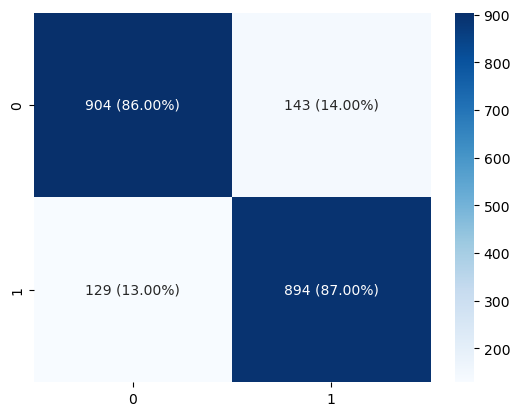

In [78]:
model(xgb,x_train,y_train,x_test,y_test)

Sooo, done

![ML](https://static.wixstatic.com/media/37f7aa_79b2fb7d1561478088d098ee2f4e1f85~mv2.png/v1/fill/w_640,h_640,al_c,q_90,usm_0.66_1.00_0.01,enc_auto/37f7aa_79b2fb7d1561478088d098ee2f4e1f85~mv2.png)

<a id="23"></a>
# Conclusion

In general, for churn prediction, minimizing false negatives (i.e., correctly identifying all customers who are likely to churn) may be more important than minimizing false positives (i.e., incorrectly identifying customers as likely to churn when they are not). So we for business could be more useful to look at F1 score than accuracy, for example.
An F1 score of 85% is generally considered to be a good score for a binary classification model. But not perfect and there are a lot of ways to improve it, especially with real customer data.

Thank you for reading my notebook! I'm glad if it was helpful <3